### 读取数据,将y转化成0,1形式

In [82]:
import pandas as pd
import numpy as np

In [83]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

In [84]:
from sklearn.preprocessing import LabelEncoder

In [85]:
x = df.iloc[:, 2:].values
y = df.loc[:, 1].values

In [86]:
np.unique(y)

array(['B', 'M'], dtype=object)

In [87]:
le = LabelEncoder()

In [88]:
y = le.fit_transform(y)

In [89]:
np.unique(y)

array([0, 1])

### 创建训练集合测试集

In [147]:
from sklearn.model_selection import train_test_split

In [196]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [197]:
# 使用pipeline统一处理数据
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [198]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state=1))])

In [199]:
pipe_lr.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [200]:
print("tet Accuracy: %.3f" %pipe_lr.score(x_test, y_test))

tet Accuracy: 0.936


### k折交叉验证

In [201]:
import numpy as np

In [202]:
from sklearn.cross_validation import StratifiedKFold

In [203]:
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=1)

In [204]:
scores = []

In [205]:
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(x_train[train], y_train[train])
    score = pipe_lr.score(x_train[test], y_train[test])
    scores.append(score)
    print('Fole:%s, Class dist:%s, Acc:%3f' % (k+1, np.bincount(y_train[train]), score))

Fole:1, Class dist:[224 134], Acc:0.975000
Fole:2, Class dist:[224 134], Acc:0.975000
Fole:3, Class dist:[224 134], Acc:0.950000
Fole:4, Class dist:[224 134], Acc:0.875000
Fole:5, Class dist:[224 134], Acc:0.950000
Fole:6, Class dist:[224 134], Acc:0.950000
Fole:7, Class dist:[224 134], Acc:0.950000
Fole:8, Class dist:[224 134], Acc:0.975000
Fole:9, Class dist:[224 134], Acc:1.000000
Fole:10, Class dist:[225 135], Acc:0.973684


In [212]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.957 +/- 0.032


In [206]:
# 使用cross_cal_score返回交叉验证的分数
from sklearn.model_selection import cross_val_score

In [207]:
scores = cross_val_score(estimator=pipe_lr,
                        X=x_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)

In [208]:
print("cs accuracy scores: %s" %scores)

cs accuracy scores: [0.975      0.975      0.95       0.875      0.95       0.95
 0.95       0.975      1.         0.97368421]


### 使用学习率曲线

In [209]:
import matplotlib.pyplot as plt

In [210]:
from sklearn.learning_curve import learning_curve

In [211]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('clf', LogisticRegression(penalty='l2', random_state=0))])

In [179]:
train_size, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                      X = x_train,
                                                      y = y_train,
                                                      train_sizes = np.linspace(0.1, 1.0, 10),
                                                      cv = 10, 
                                                      n_jobs = 1)

/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:209: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


In [180]:
train_mean = np.mean(train_scores, axis = 1)

In [181]:
train_std = np.std(train_scores, axis=1)

In [182]:
test_mean = np.mean(test_scores, axis=1)

In [183]:
test_std = np.std(test_scores, axis=1)

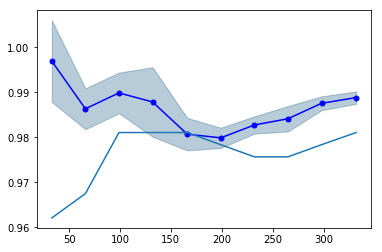

In [184]:
plt.plot(train_size, train_mean,
        color = 'blue', marker='o',
        markersize=5, 
        label='training accuracy')
plt.fill_between(train_size,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(train_size, test_mean)
plt.fill_between(train_size,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='green')
plt.show()

### 网格搜索调参

In [185]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

In [186]:
pipe_scv = Pipeline([('scl', StandardScaler()),
                   ('clf', LogisticRegression(random_state=1))])

In [187]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

In [188]:
param_grid = [{
    'clf_C': param_range,
    'clf_kernel':['linear']},
{
    'clf_C': param_range,
    'clf_gamma': param_range,
    'clf_kernel':['rbf']
}]

In [189]:
gs = GridSearchCV(estimator=pipe_scv,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

In [213]:
gs = gs.fit(x_train, y_train)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10d11a150, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/pengyi/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/pengy.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10d11a150, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/pengyi/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/pengy.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gs = gs.fit(x_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 22, 2, 24, 33, 443392, tzinfo=tzutc()), 'msg_id': '20E989B175204769BFAF3AA876F17B52', 'msg_type': 'execute_request', 'session': 'DA1CA66097DF44ED9CC63D067B0F6005', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '20E989B175204769BFAF3AA876F17B52', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'DA1CA66097DF44ED9CC63D067B0F6005']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'gs = gs.fit(x_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 22, 2, 24, 33, 443392, tzinfo=tzutc()), 'msg_id': '20E989B175204769BFAF3AA876F17B52', 'msg_type': 'execute_request', 'session': 'DA1CA66097DF44ED9CC63D067B0F6005', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '20E989B175204769BFAF3AA876F17B52', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'DA1CA66097DF44ED9CC63D067B0F6005'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gs = gs.fit(x_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 22, 2, 24, 33, 443392, tzinfo=tzutc()), 'msg_id': '20E989B175204769BFAF3AA876F17B52', 'msg_type': 'execute_request', 'session': 'DA1CA66097DF44ED9CC63D067B0F6005', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '20E989B175204769BFAF3AA876F17B52', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='gs = gs.fit(x_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'gs = gs.fit(x_train, y_train)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('gs = gs.fit(x_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('gs = gs.fit(x_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='gs = gs.fit(x_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-213-4b788313001e>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1268f2198, execution_..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x129097ed0, file "<ipython-input-213-4b788313001e>", line 1>
        result = <ExecutionResult object at 1268f2198, execution_..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x129097ed0, file "<ipython-input-213-4b788313001e>", line 1>, result=<ExecutionResult object at 1268f2198, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x129097ed0, file "<ipython-input-213-4b788313001e>", line 1>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np', 'df = pd.read_csv("https://archive.ics.uci.edu/ml...s/breast-cancer-visonsin/wdbc.data", header=None)', 'df = pd.read_csv("https://archive.ics.uci.edu/ml...s/breast-cancer-wisonsin/wdbc.data", header=None)', 'df = pd.read_csv("https://archive.ics.uci.edu/ml.../breast-cancer-wisconsin/wdbc.data", header=None)', 'from sklearn.preprocessing import LabelEncoder', 'x = df.iloc[:, 2:].values\ny = df.loc[:, 1].values', 'np.unique(y)', 'le = LabelEncoder()', 'y = le.fit_transform(y)', 'np.unique(y)', 'from sklearn.model_selection import train_test_split', 'x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)', '# 处理数据', '# 处理数据\nfrom sklearn.preprocessing import Standar...cRegression\nfrom sklearn.pipeline import Pipeline', "pipe_lr = Pipeline([('scl', StandardScaler()),\n ...    ('clf', LogisticRegression(random_state=1))])", 'pipe_lr.fit(x_train, y_train)', 'print("tet Accuracy:" %pipe_lr.score(x_test, y_test))', 'print("tet Accuracy: %.3f" %pipe_lr.score(x_test, y_test))', 'import numpy as np', ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {7: array(['B', 'M'], dtype=object), 10: array([0, 1]), 16: Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), 33: array(['B', 'M'], dtype=object), 36: array([0, 1]), 41: Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), 67: <matplotlib.collections.PolyCollection object>, 86: array(['B', 'M'], dtype=object), 89: array([0, 1]), 94: Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'StratifiedKFold': <class 'sklearn.cross_validation.StratifiedKFold'>, ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np', 'df = pd.read_csv("https://archive.ics.uci.edu/ml...s/breast-cancer-visonsin/wdbc.data", header=None)', 'df = pd.read_csv("https://archive.ics.uci.edu/ml...s/breast-cancer-wisonsin/wdbc.data", header=None)', 'df = pd.read_csv("https://archive.ics.uci.edu/ml.../breast-cancer-wisconsin/wdbc.data", header=None)', 'from sklearn.preprocessing import LabelEncoder', 'x = df.iloc[:, 2:].values\ny = df.loc[:, 1].values', 'np.unique(y)', 'le = LabelEncoder()', 'y = le.fit_transform(y)', 'np.unique(y)', 'from sklearn.model_selection import train_test_split', 'x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)', '# 处理数据', '# 处理数据\nfrom sklearn.preprocessing import Standar...cRegression\nfrom sklearn.pipeline import Pipeline', "pipe_lr = Pipeline([('scl', StandardScaler()),\n ...    ('clf', LogisticRegression(random_state=1))])", 'pipe_lr.fit(x_train, y_train)', 'print("tet Accuracy:" %pipe_lr.score(x_test, y_test))', 'print("tet Accuracy: %.3f" %pipe_lr.score(x_test, y_test))', 'import numpy as np', ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {7: array(['B', 'M'], dtype=object), 10: array([0, 1]), 16: Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), 33: array(['B', 'M'], dtype=object), 36: array([0, 1]), 41: Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), 67: <matplotlib.collections.PolyCollection object>, 86: array(['B', 'M'], dtype=object), 89: array([0, 1]), 94: Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'StratifiedKFold': <class 'sklearn.cross_validation.StratifiedKFold'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/pengyi/PycharmProjects/MachineLearning/<ipython-input-213-4b788313001e> in <module>()
----> 1 gs = gs.fit(x_train, y_train)

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=10, error_score='raise',
       ...jobs', refit=True, scoring='accuracy', verbose=0), X=array([[1.149e+01, 1.459e+01, 7.399e+01, ..., 7...., ..., 9.653e-02, 2.112e-01,
        8.732e-02]]), y=array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,...0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0]))
    833         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    834             Target relative to X for classification or regression;
    835             None for unsupervised learning.
    836 
    837         """
--> 838         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...obs', refit=True, scoring='accuracy', verbose=0)>
        X = array([[1.149e+01, 1.459e+01, 7.399e+01, ..., 7...., ..., 9.653e-02, 2.112e-01,
        8.732e-02]])
        y = array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,...0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0])
        self.param_grid = [{'clf_C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf_kernel': ['linear']}, {'clf_C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf_gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf_kernel': ['rbf']}]
    839 
    840 
    841 class RandomizedSearchCV(BaseSearchCV):
    842     """Randomized search on hyper parameters.

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=10, error_score='raise',
       ...jobs', refit=True, scoring='accuracy', verbose=0), X=array([[1.149e+01, 1.459e+01, 7.399e+01, ..., 7...., ..., 9.653e-02, 2.112e-01,
        8.732e-02]]), y=array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,...0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0]), parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    569         )(
    570             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    571                                     train, test, self.verbose, parameters,
    572                                     self.fit_params, return_parameters=True,
    573                                     error_score=self.error_score)
--> 574                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    575                 for train, test in cv)
    576 
    577         # Out is a list of triplet: score, estimator, n_test_samples
    578         n_fits = len(out)

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Oct 22 10:24:33 2018
PID: 41527                 Python 3.6.2: /Users/pengyi/anaconda3/bin/python
...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), array([[1.149e+01, 1.459e+01, 7.399e+01, ..., 7...., ..., 9.653e-02, 2.112e-01,
        8.732e-02]]), array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,...0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0]), make_scorer(accuracy_score), array([ 39,  40,  41,  42,  44,  45,  46,  47,  ..., 390,
       391, 392, 393, 394, 395, 396, 397]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 30, 31, 32, 33,
       34, 35, 36, 37, 38, 43]), 0, {'clf_C': 0.0001, 'clf_kernel': 'linear'}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), array([[1.149e+01, 1.459e+01, 7.399e+01, ..., 7...., ..., 9.653e-02, 2.112e-01,
        8.732e-02]]), array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,...0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0]), make_scorer(accuracy_score), array([ 39,  40,  41,  42,  44,  45,  46,  47,  ..., 390,
       391, 392, 393, 394, 395, 396, 397]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 30, 31, 32, 33,
       34, 35, 36, 37, 38, 43]), 0, {'clf_C': 0.0001, 'clf_kernel': 'linear'}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), X=array([[1.149e+01, 1.459e+01, 7.399e+01, ..., 7...., ..., 9.653e-02, 2.112e-01,
        8.732e-02]]), y=array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,...0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0]), scorer=make_scorer(accuracy_score), train=array([ 39,  40,  41,  42,  44,  45,  46,  47,  ..., 390,
       391, 392, 393, 394, 395, 396, 397]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 30, 31, 32, 33,
       34, 35, 36, 37, 38, 43]), verbose=0, parameters={'clf_C': 0.0001, 'clf_kernel': 'linear'}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1659     fit_params = fit_params if fit_params is not None else {}
   1660     fit_params = dict([(k, _index_param_value(X, v, train))
   1661                       for k, v in fit_params.items()])
   1662 
   1663     if parameters is not None:
-> 1664         estimator.set_params(**parameters)
        estimator.set_params = <bound method Pipeline.set_params of Pipeline(me....0001,
          verbose=0, warm_start=False))])>
        parameters = {'clf_C': 0.0001, 'clf_kernel': 'linear'}
   1665 
   1666     start_time = time.time()
   1667 
   1668     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in set_params(self=Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), **kwargs={'clf_C': 0.0001, 'clf_kernel': 'linear'})
    139 
    140         Returns
    141         -------
    142         self
    143         """
--> 144         self._set_params('steps', **kwargs)
        self._set_params = <bound method _BaseComposition._set_params of Pi....0001,
          verbose=0, warm_start=False))])>
        kwargs = {'clf_C': 0.0001, 'clf_kernel': 'linear'}
    145         return self
    146 
    147     def _validate_steps(self):
    148         names, estimators = zip(*self.steps)

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py in _set_params(self=Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), attr='steps', **params={'clf_C': 0.0001, 'clf_kernel': 'linear'})
     44         names, _ = zip(*getattr(self, attr))
     45         for name in list(six.iterkeys(params)):
     46             if '__' not in name and name in names:
     47                 self._replace_estimator(attr, name, params.pop(name))
     48         # 3. Step parameters and other initilisation arguments
---> 49         super(_BaseComposition, self).set_params(**params)
        self.set_params = <bound method Pipeline.set_params of Pipeline(me....0001,
          verbose=0, warm_start=False))])>
        params = {'clf_C': 0.0001, 'clf_kernel': 'linear'}
     50         return self
     51 
     52     def _replace_estimator(self, attr, name, new_val):
     53         # assumes `name` is a valid estimator name

...........................................................................
/Users/pengyi/anaconda3/lib/python3.6/site-packages/sklearn/base.py in set_params(self=Pipeline(memory=None,
     steps=[('scl', Standa...0.0001,
          verbose=0, warm_start=False))]), **params={'clf_C': 0.0001, 'clf_kernel': 'linear'})
    278                 # simple objects case
    279                 if key not in valid_params:
    280                     raise ValueError('Invalid parameter %s for estimator %s. '
    281                                      'Check the list of available parameters '
    282                                      'with `estimator.get_params().keys()`.' %
--> 283                                      (key, self.__class__.__name__))
        key = 'clf_C'
        self.__class__.__name__ = 'Pipeline'
    284                 setattr(self, key, value)
    285         return self
    286 
    287     def __repr__(self):

ValueError: Invalid parameter clf_C for estimator Pipeline. Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________